 # 回帰2:客船沈没事故での生存予測

In [1]:
import pickle
from sklearn import tree
from sklearn.model_selection import train_test_split
import unittest
import doctest
import os

from domain import CSVRepository, SQLRepository, CategoricalData, DataVisualization, convert_categoricals
import pandas as pd

path = os.path.dirname(os.path.abspath(__file__))
repo = SQLRepository(table='Survived')
# repo = CSVRepository(file=path + '/data/Survived.csv')

 ## データの内容
 | 列名 | 内容 |
 | --- | --- |
 | PassengerId | 乗客ID |
 | Pclass | チケットクラス（1等、2等、3等）|
 | Age | 年齢 |
 | Parch | 同乗した、自身の親と子供の総数 |
 | Fare | 運賃 |
 | Embarked | 搭乗港 |
 | Survived | 1:生存,0:死亡 |
 | Sex | 性別 |
 | SibSp | 同乗した兄弟や配偶者の総数 |
 | Ticket | チケットID |
 | Cabin | 部屋番号 |

In [2]:
df = repo.get_data()
df.head(3)

,PassengerId,Pclass,Age,Parch,Fare,Embarked,Survived,Sex,SibSp,Ticket,Cabin
0,1,3,22.0,0,7.2500,S,0,male,1,A/5 21171,
1,2,1,38.0,0,71.2833,C,1,female,1,PC 17599,C85
2,3,3,26.0,0,7.9250,S,1,female,0,STON/O2. 3101282,


 ## 問題背景
 客船沈没事故で、どのような人が生き残ったかを分析します。このデータを用いて、客船の乗客の特徴量から生存者を予測するモデルを作成します。

 ## データ分析の方法検討
 - 乗客の特徴から沈没時に生存か死亡かに分類するモデルを作成する。また、その過程で、どのような特徴を持つ人が生き残れたかを考察する。
 - 特徴量を「チケットクラス、年齢、同乗した、自身の親と子供の総数、運賃、搭乗港、性別、同乗した兄弟や配偶者の総数、部屋番号」、目的変数を「生存」（1:生存,0:死亡）として、客船の乗客の生存を予測する。

 分析の実施

 ### データの概要

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Age          714 non-null    float64
 3   Parch        891 non-null    int64  
 4   Fare         891 non-null    float64
 5   Embarked     891 non-null    object 
 6   Survived     891 non-null    int64  
 7   Sex          891 non-null    object 
 8   SibSp        891 non-null    int64  
 9   Ticket       891 non-null    object 
 10  Cabin        891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


 ### データの統計量

In [4]:
df.describe()

,PassengerId,Pclass,Age,Parch,Fare,Survived,SibSp
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.381594,32.204208,0.383838,0.523008
std,257.353842,0.836071,14.526497,0.806057,49.693429,0.486592,1.102743
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,7.910400,0.000000,0.000000
50%,446.000000,3.000000,28.000000,0.000000,14.454200,0.000000,0.000000
75%,668.500000,3.000000,38.000000,0.000000,31.000000,1.000000,1.000000
max,891.000000,3.000000,80.000000,6.000000,512.329200,1.000000,8.000000


 ### データの特徴量の相関確認

In [5]:
categorical_cols = ['Sex', 'Ticket', 'Cabin', 'Embarked']
df_conv = convert_categoricals(df, categorical_cols)
df_conv.corr()

,PassengerId,Pclass,Age,Parch,Fare,Embarked,Survived,Sex,SibSp,Ticket,Cabin
PassengerId,1.000000,-0.035144,0.036847,-0.001652,0.012658,0.012985,-0.005007,0.042939,-0.057527,-0.056554,-0.000637
Pclass,-0.035144,1.000000,-0.369226,0.018443,-0.549500,0.173511,-0.338481,0.131900,0.083081,0.319869,-0.537419
Age,0.036847,-0.369226,1.000000,-0.189119,0.096067,-0.044830,-0.077221,0.093254,-0.308247,-0.075934,0.167432
Parch,-0.001652,0.018443,-0.189119,1.000000,0.216225,0.043351,0.081629,-0.245489,0.414838,0.020003,0.033585
Fare,0.012658,-0.549500,0.096067,0.216225,1.000000,-0.230365,0.257307,-0.182333,0.159651,-0.013885,0.310987
Embarked,0.012985,0.173511,-0.044830,0.043351,-0.230365,1.000000,-0.176509,0.118492,0.071480,0.011146,-0.070245
Survived,-0.005007,-0.338481,-0.077221,0.081629,0.257307,-0.176509,1.000000,-0.543351,-0.035322,-0.164549,0.276235
Sex,0.042939,0.131900,0.093254,-0.245489,-0.182333,0.118492,-0.543351,1.000000,-0.114631,0.059372,-0.137704
SibSp,-0.057527,0.083081,-0.308247,0.414838,0.159651,0.071480,-0.035322,-0.114631,1.000000,0.079461,-0.024829
Ticket,-0.056554,0.319869,-0.075934,0.020003,-0.013885,0.011146,-0.164549,0.059372,0.079461,1.000000,-0.176515


 ### データの数値変数確認

In [6]:
df.select_dtypes(include='number').columns

Index(['PassengerId', 'Pclass', 'Age', 'Parch', 'Fare', 'Survived', 'SibSp'], dtype='object')

 ### データのカテゴリ変数確認

In [7]:
df.select_dtypes(include='object').columns

Index(['Embarked', 'Sex', 'Ticket', 'Cabin'], dtype='object')

 ### 性別カテゴリ

In [8]:
sex = CategoricalData(df, 'Sex')

In [9]:
sex.show()

Sex
male      577
female    314
Name: count, dtype: int64

<Axes: xlabel='Sex'>

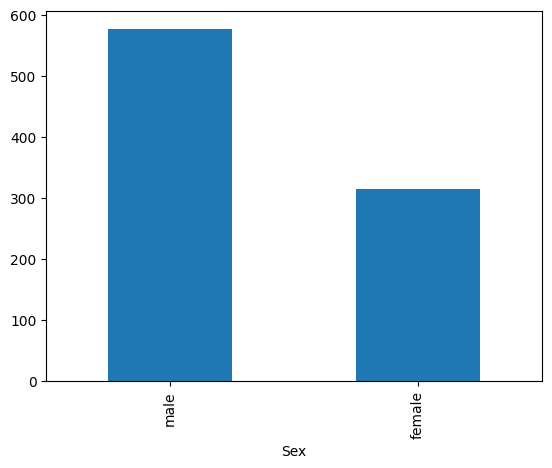

In [10]:
sex.plot()

 ### 性別カテゴリの数値変換

<Axes: xlabel='Sex'>

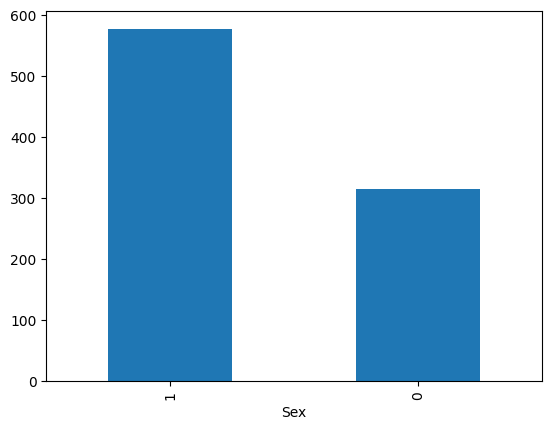

In [11]:
categorical_cols = ['Sex']
df_conv = convert_categoricals(df, categorical_cols)
conv_species = CategoricalData(df_conv, 'Sex')
conv_species.plot()

 ### チケットIDカテゴリ

In [12]:
ticket = CategoricalData(df, 'Ticket')

In [13]:
ticket.show()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

<Axes: xlabel='Ticket'>

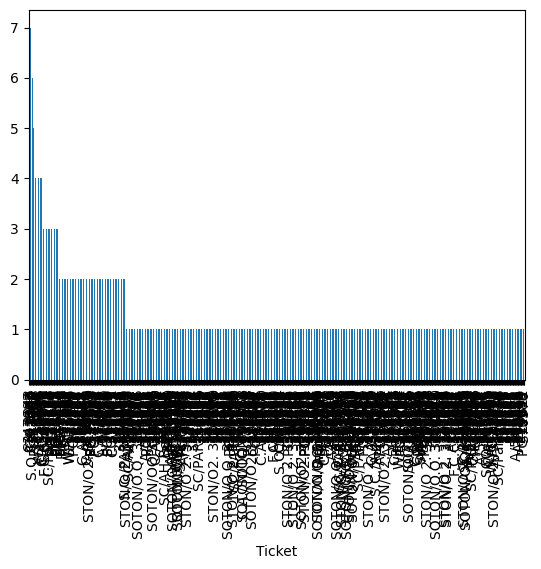

In [14]:
ticket.plot()

 ### チケットIDカテゴリの数値変換

<Axes: xlabel='Ticket'>

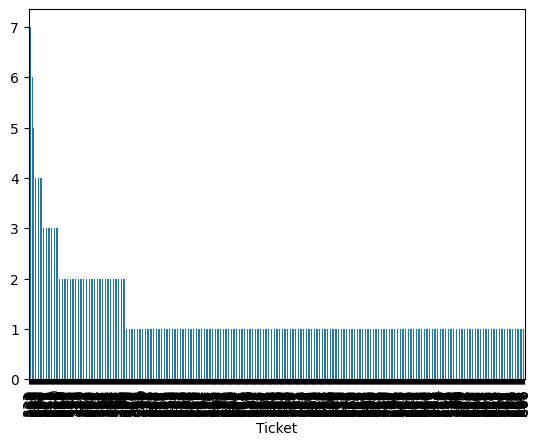

In [15]:
categorical_cols = ['Ticket']
df_conv = convert_categoricals(df, categorical_cols)
conv_species = CategoricalData(df_conv, 'Ticket')
conv_species.plot()

 ### 部屋番号カテゴリ

In [16]:
cabin = CategoricalData(df, 'Cabin')

In [17]:
cabin.show()

Cabin
               687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: count, Length: 148, dtype: int64

<Axes: xlabel='Cabin'>

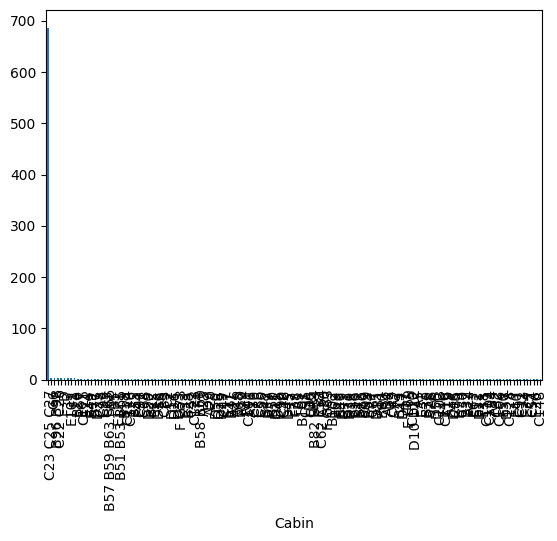

In [18]:
cabin.plot()

 ### 部屋番号カテゴリの数値変換

<Axes: xlabel='Cabin'>

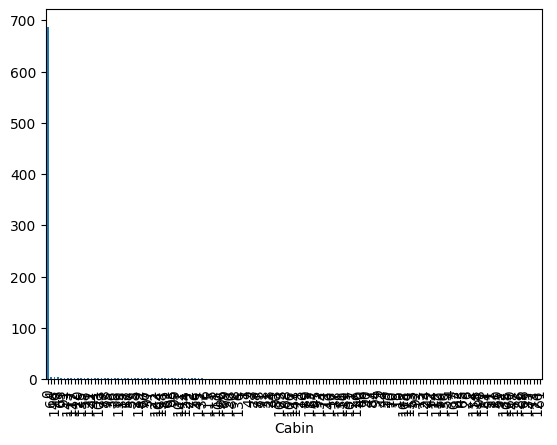

In [19]:
categorical_cols = ['Cabin']
df_conv = convert_categoricals(df, categorical_cols)
conv_species = CategoricalData(df_conv, 'Cabin')
conv_species.plot()

 ### 搭乗港カテゴリ

In [20]:
embarked = CategoricalData(df, 'Embarked')

In [21]:
embarked.show()

Embarked
S    644
C    168
Q     77
       2
Name: count, dtype: int64

<Axes: xlabel='Embarked'>

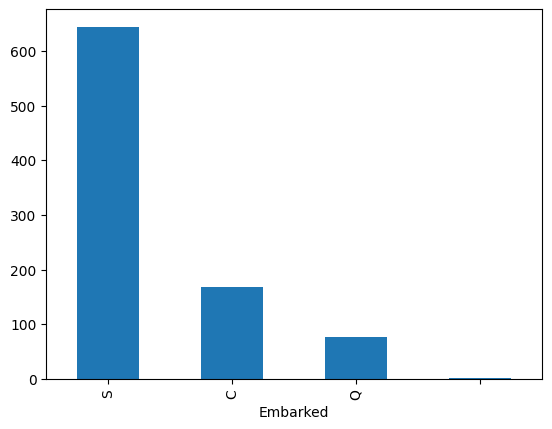

In [22]:
embarked.plot()

 ### 搭乗港カテゴリの数値変換

<Axes: xlabel='Embarked'>

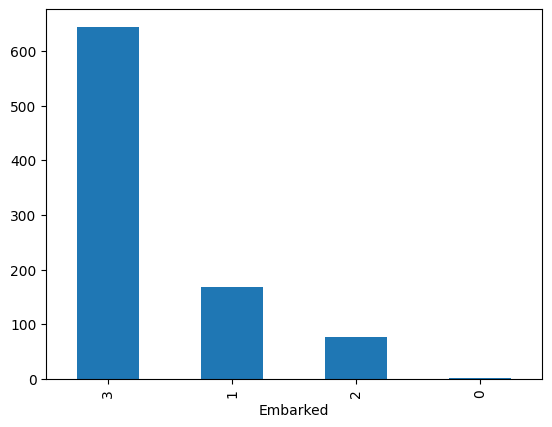

In [23]:
categorical_cols = ['Embarked']
df_conv = convert_categoricals(df, categorical_cols)
conv_species = CategoricalData(df_conv, 'Embarked')
conv_species.plot()

 ### ダミー変数化

In [24]:
df_dummy = pd.get_dummies(df, columns=['Survived'])
df_dummy

,PassengerId,Pclass,Age,Parch,Fare,Embarked,Sex,SibSp,Ticket,Cabin,Survived_0,Survived_1
0,1,3,22.0,0,7.2500,S,male,1,A/5 21171,,True,False
1,2,1,38.0,0,71.2833,C,female,1,PC 17599,C85,False,True
2,3,3,26.0,0,7.9250,S,female,0,STON/O2. 3101282,,False,True
3,4,1,35.0,0,53.1000,S,female,1,113803,C123,False,True
4,5,3,35.0,0,8.0500,S,male,0,373450,,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,27.0,0,13.0000,S,male,0,211536,,True,False
887,888,1,19.0,0,30.0000,S,female,0,112053,B42,False,True
888,889,3,NaN,2,23.4500,S,female,1,W./C. 6607,,True,False
889,890,1,26.0,0,30.0000,C,male,0,111369,C148,False,True


 ### データの可視化

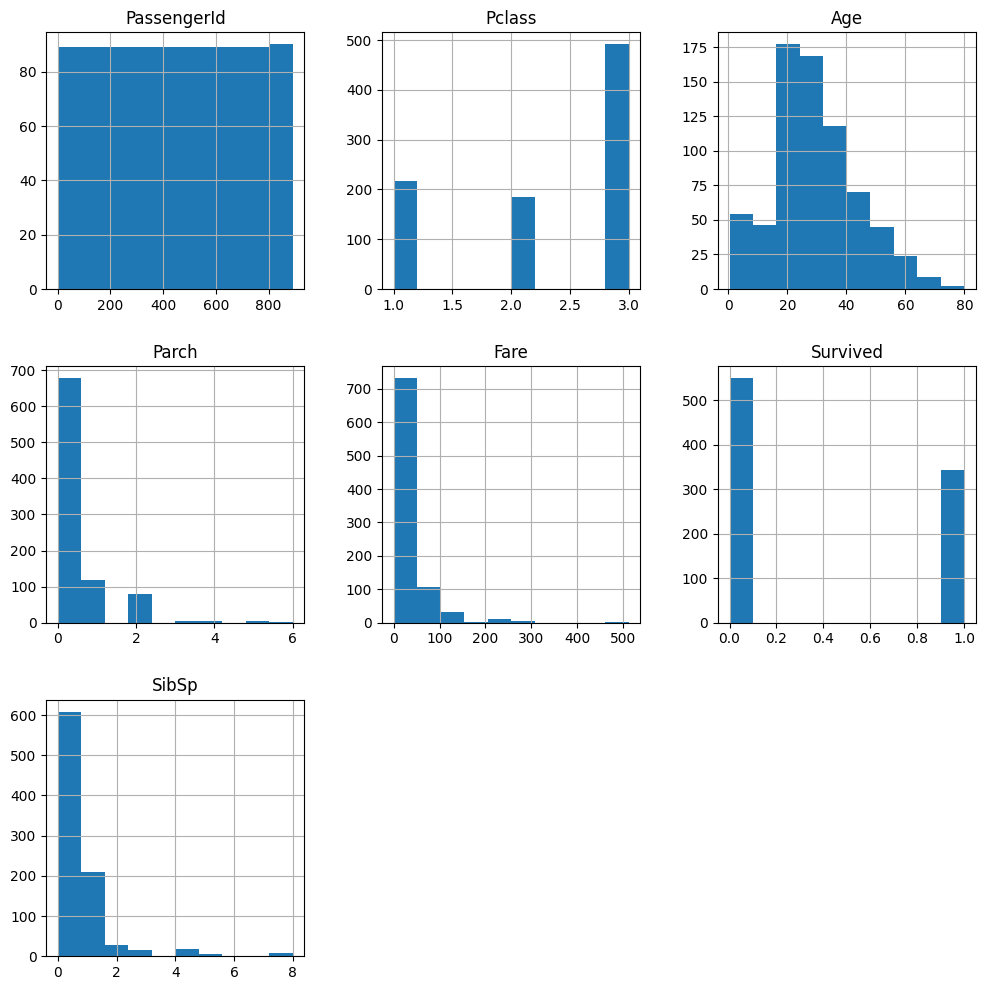

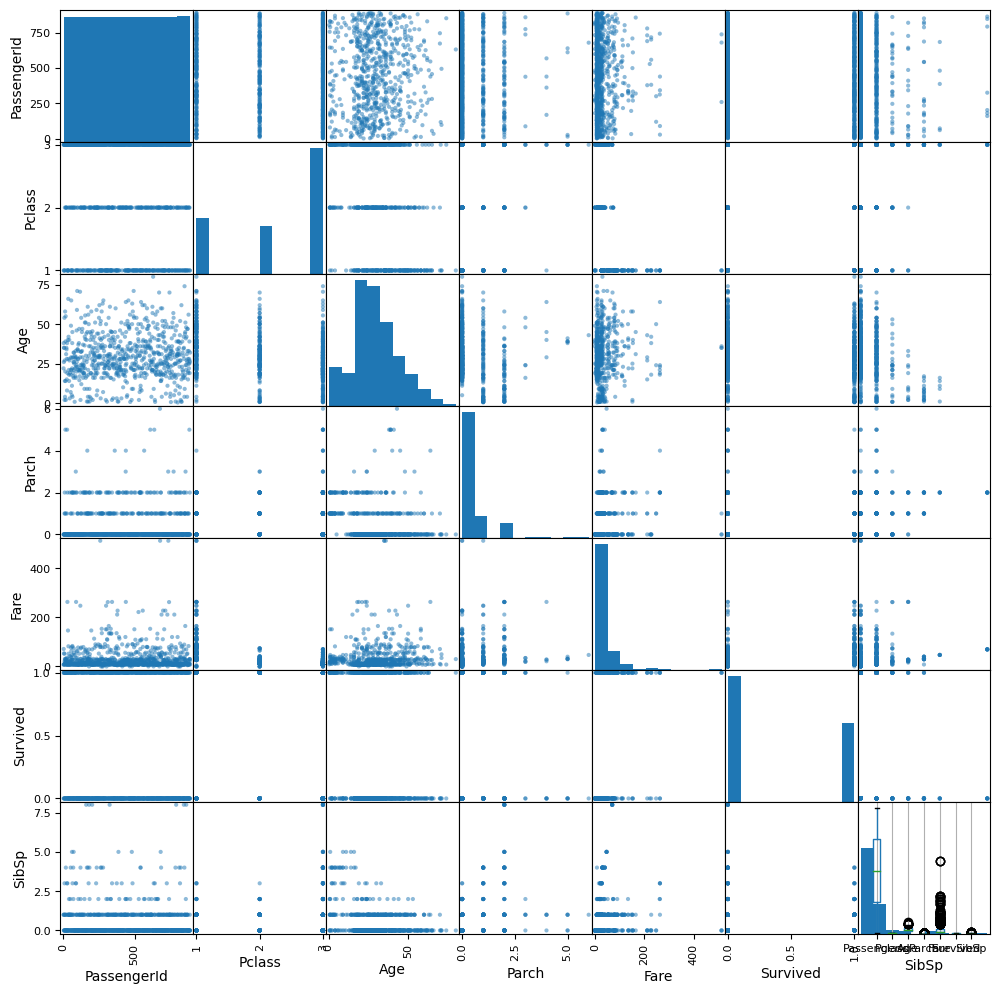

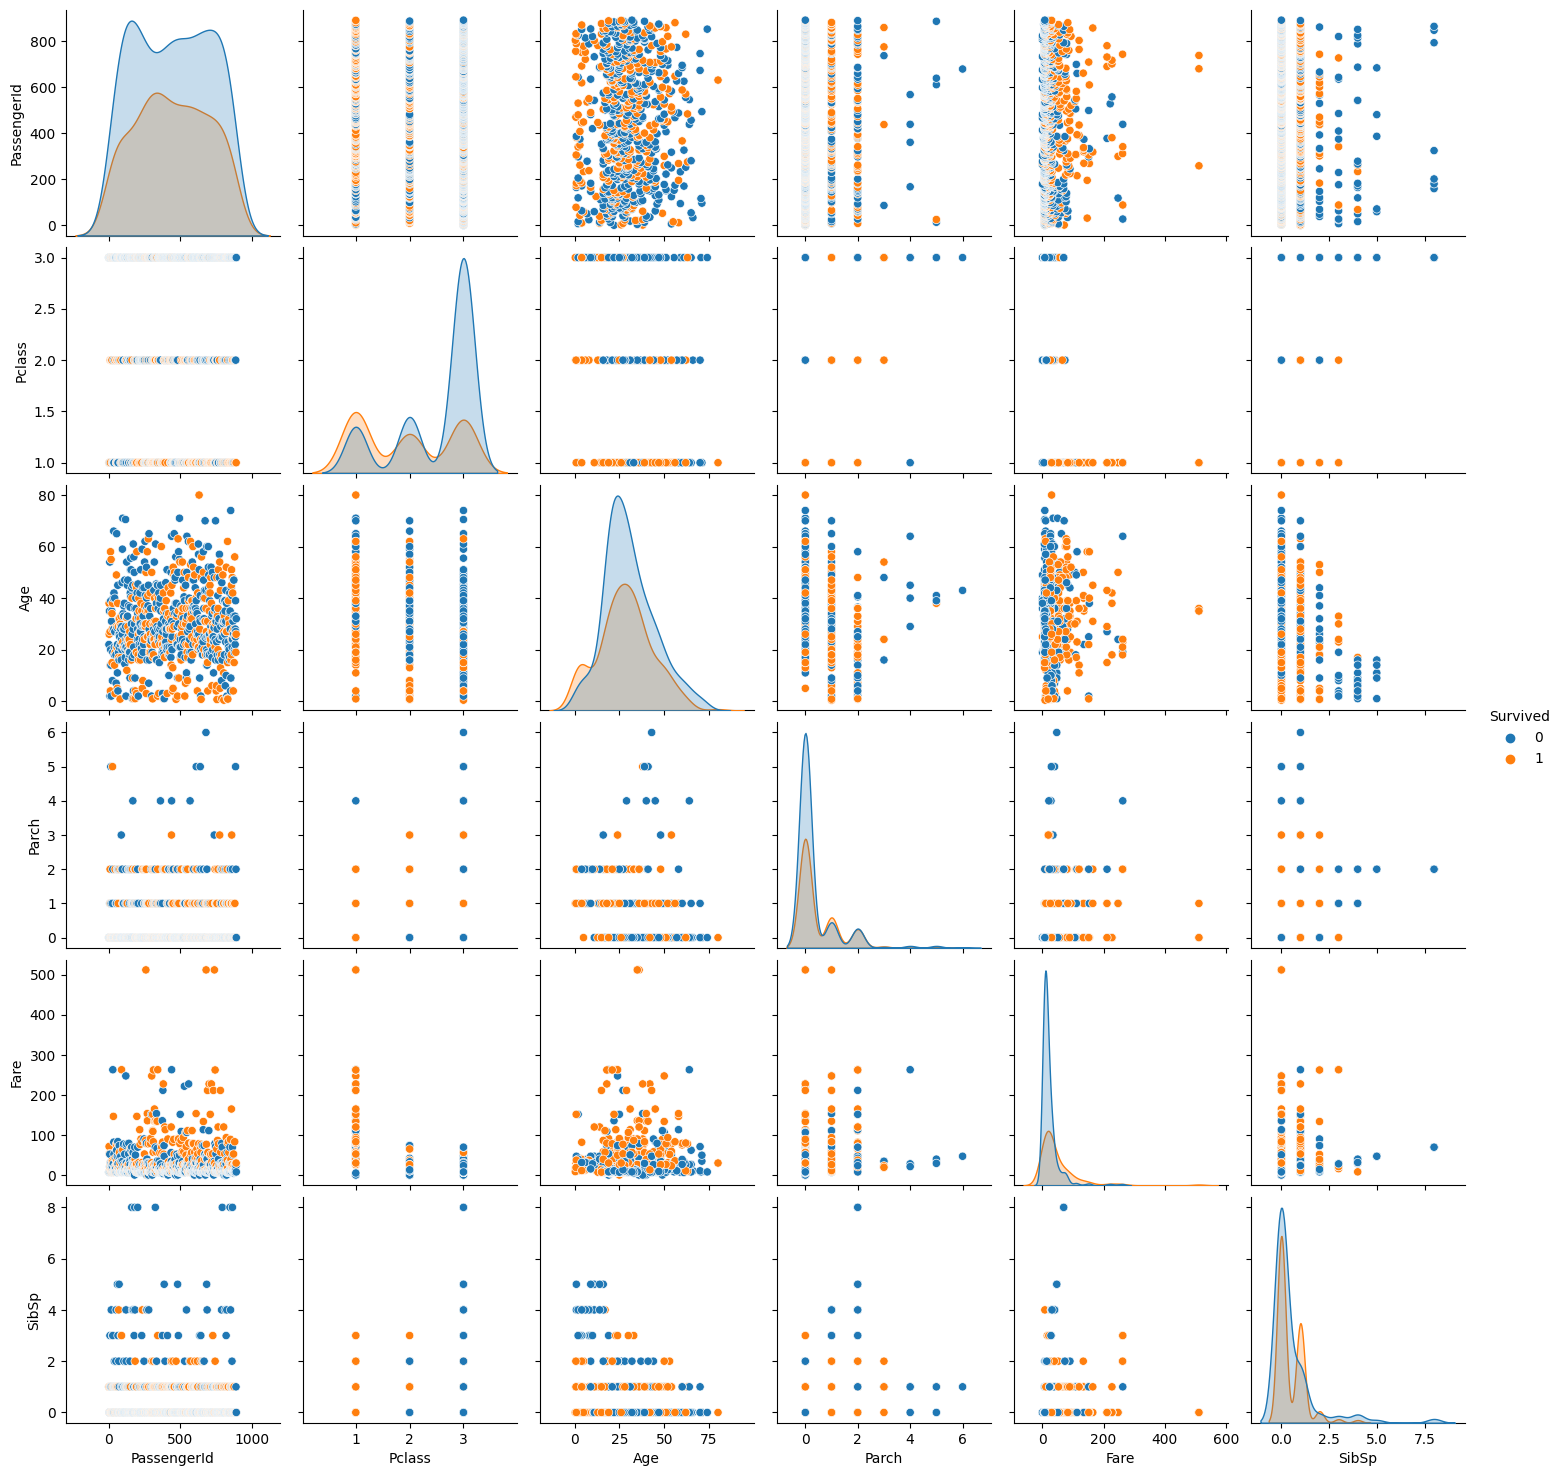

In [25]:
dv = DataVisualization(df)
dv.df_all('Survived')

 ## データの前処理

In [26]:
df = repo.get_data()
df.head(2)

df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

 ### 欠損地処理（行削除・全体代表値埋め、グループ代表値埋め）

In [27]:
df.isnull().sum()
df.shape

df['Age'] = df['Age'].fillna(df['Age'].mean())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

 ### 各手法を必要に応じて実施

 - 外れ値の除外
 - 多項式特徴量・交互作用特徴量の追加
 - 特徴量の絞り込み
 - 標準化

In [28]:
col = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

x = df[col]
y = df['Survived']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0)

x_train.shape

(712, 5)

 ## モデルの作成と学習

 ### 未学習状態モデルの生成（分類なら決定木、回帰なら線形回帰）

In [29]:
model = tree.DecisionTreeClassifier(
    max_depth=5, random_state=0, class_weight='balanced')

 ### 訓練データで学習（必要に応じて不均衡データ補正）

In [30]:
model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=0)

 ## モデルの評価

 ### 検証データで評価し指標確認（分類なら正解率、回帰なら決定係数）

In [31]:
model.score(x_test, y_test)

0.7374301675977654

In [32]:
def learn(x, t, depth=3):
    x_train, x_test, y_train, y_test = train_test_split(
        x, t, test_size=0.2, random_state=0)
    model = tree.DecisionTreeClassifier(
        max_depth=depth, random_state=0, class_weight='balanced')
    model.fit(x_train, y_train)

    score = model.score(x_train, y_train)
    score2 = model.score(x_test, y_test)
    return round(score, 3), round(score2, 3), model


for j in range(1, 15):
    train_score, test_score, model = learn(x, y, depth=j)
    sentence = '訓練データの正解率{}'
    sentence2 = 'テストデータの正解率{}'
    total_sentence = '深さ{}:' + sentence + sentence2
    print(total_sentence.format(j, train_score, test_score))

深さ1:訓練データの正解率0.659テストデータの正解率0.704
深さ2:訓練データの正解率0.699テストデータの正解率0.732
深さ3:訓練データの正解率0.704テストデータの正解率0.737
深さ4:訓練データの正解率0.698テストデータの正解率0.726
深さ5:訓練データの正解率0.722テストデータの正解率0.737
深さ6:訓練データの正解率0.77テストデータの正解率0.698
深さ7:訓練データの正解率0.771テストデータの正解率0.648
深さ8:訓練データの正解率0.781テストデータの正解率0.631
深さ9:訓練データの正解率0.83テストデータの正解率0.704
深さ10:訓練データの正解率0.851テストデータの正解率0.687
深さ11:訓練データの正解率0.878テストデータの正解率0.676
深さ12:訓練データの正解率0.892テストデータの正解率0.654
深さ13:訓練データの正解率0.909テストデータの正解率0.654
深さ14:訓練データの正解率0.92テストデータの正解率0.654


 ### NG:改善案検討前処理に戻る

In [33]:
# repo = SQLRepository(table='Survived')
repo = CSVRepository(file=path + '/data/Survived.csv')

 #### Take1
 - Age列の平均値と中央値を確認する

In [34]:
# 前処理
df = repo.get_data()
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

col = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
x = df[col]
y = df['Survived']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0)

# モデルの作成と学習
model = tree.DecisionTreeClassifier(
    max_depth=5, random_state=0, class_weight='balanced')
model.fit(x_train, y_train)

# モデルの評価
model.score(x_test, y_test)

0.7541899441340782

 #### Take2
 - グループ別集計

In [35]:
df2 = repo.get_data()

categorical_cols = ['Sex', 'Ticket', 'Cabin', 'Embarked']
df_conv = convert_categoricals(df2, categorical_cols)
print(df_conv.groupby('Survived').mean()['Age'])
print(df_conv.groupby('Pclass').median()['Age'])
print(pd.pivot_table(df, index='Survived',
      columns='Pclass', values='Age', aggfunc='median'))
print(pd.pivot_table(df, index='Survived',
      columns='Pclass', values='Age', aggfunc=max))

Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64
Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64
Pclass       1     2     3
Survived                  
0         38.5  30.0  28.0
1         33.5  28.0  27.0
Pclass       1     2     3
Survived                  
0         71.0  70.0  74.0
1         80.0  62.0  63.0


In [36]:
# 前処理
is_null = df2['Age'].isnull()

df2.loc[(df2['Pclass'] == 1) & (df2['Survived'] == 0) & (is_null), 'Age'] = 43
df2.loc[(df2['Pclass'] == 1) & (df2['Survived'] == 1) & (is_null), 'Age'] = 35

df2.loc[(df2['Pclass'] == 2) & (df2['Survived'] == 0) & (is_null), 'Age'] = 33
df2.loc[(df2['Pclass'] == 2) & (df2['Survived'] == 1) & (is_null), 'Age'] = 25

df2.loc[(df2['Pclass'] == 3) & (df2['Survived'] == 0) & (is_null), 'Age'] = 26
df2.loc[(df2['Pclass'] == 3) & (df2['Survived'] == 1) & (is_null), 'Age'] = 20

col = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
x = df2[col]
y = df2['Survived']

for j in range(1, 15):
    s1, s2, m = learn(x, y, depth=j)
    sentence = '深さ{}:訓練データの精度{}::テストデータの精度{}'
    print(sentence.format(j, s1, s2))

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0)

# モデルの作成と学習
model = tree.DecisionTreeClassifier(
    max_depth=6, random_state=0, class_weight='balanced')
model.fit(x_train, y_train)

# モデルの評価
model.score(x_test, y_test)

深さ1:訓練データの精度0.659::テストデータの精度0.704
深さ2:訓練データの精度0.699::テストデータの精度0.67
深さ3:訓練データの精度0.722::テストデータの精度0.715
深さ4:訓練データの精度0.74::テストデータの精度0.704
深さ5:訓練データの精度0.76::テストデータの精度0.726
深さ6:訓練データの精度0.794::テストデータの精度0.793
深さ7:訓練データの精度0.819::テストデータの精度0.749
深さ8:訓練データの精度0.84::テストデータの精度0.749
深さ9:訓練データの精度0.885::テストデータの精度0.743
深さ10:訓練データの精度0.906::テストデータの精度0.732
深さ11:訓練データの精度0.93::テストデータの精度0.726
深さ12:訓練データの精度0.947::テストデータの精度0.737
深さ13:訓練データの精度0.961::テストデータの精度0.732
深さ14:訓練データの精度0.969::テストデータの精度0.721


0.7932960893854749

 #### Take3
 - グループ別集計
 - 特徴量に性別を追加

<Axes: xlabel='Sex'>

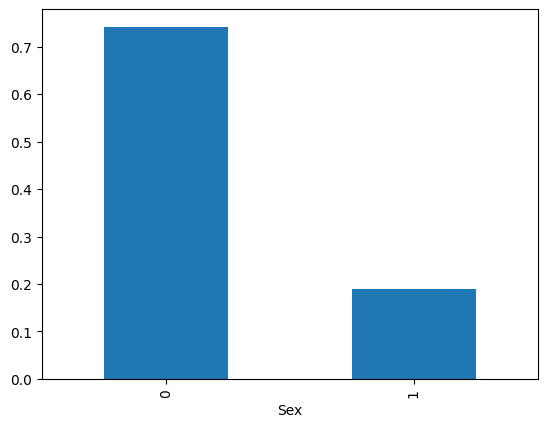

In [37]:
df3 = repo.get_data()

categorical_cols = ['Sex', 'Ticket', 'Cabin', 'Embarked']
df_conv = convert_categoricals(df3, categorical_cols)
sex = df_conv.groupby('Sex').mean()
sex['Survived']
sex['Survived'].plot(kind='bar')

In [38]:
# 前処理
is_null = df3['Age'].isnull()

df3.loc[(df3['Pclass'] == 1) & (df3['Survived'] == 0) & (is_null), 'Age'] = 43
df3.loc[(df3['Pclass'] == 1) & (df3['Survived'] == 1) & (is_null), 'Age'] = 35

df3.loc[(df3['Pclass'] == 2) & (df3['Survived'] == 0) & (is_null), 'Age'] = 33
df3.loc[(df3['Pclass'] == 2) & (df3['Survived'] == 1) & (is_null), 'Age'] = 25

df3.loc[(df3['Pclass'] == 3) & (df3['Survived'] == 0) & (is_null), 'Age'] = 26
df3.loc[(df3['Pclass'] == 3) & (df3['Survived'] == 1) & (is_null), 'Age'] = 20

col = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex']
x = df3[col]
y = df3['Survived']

male = pd.get_dummies(df3['Sex'], drop_first=True)
x_temp = pd.concat([x, male], axis=1)
x_new = x_temp.drop('Sex', axis=1)

# モデルの評価
for j in range(1, 15):
    s1, s2, m = learn(x_new, y, depth=j)
    sentence = '深さ{}:訓練データの精度{}::テストデータの精度{}'
    print(sentence.format(j, s1, s2))

深さ1:訓練データの精度0.787::テストデータの精度0.788
深さ2:訓練データの精度0.792::テストデータの精度0.782
深さ3:訓練データの精度0.847::テストデータの精度0.81
深さ4:訓練データの精度0.854::テストデータの精度0.849
深さ5:訓練データの精度0.865::テストデータの精度0.86
深さ6:訓練データの精度0.876::テストデータの精度0.866
深さ7:訓練データの精度0.904::テストデータの精度0.866
深さ8:訓練データの精度0.912::テストデータの精度0.894
深さ9:訓練データの精度0.926::テストデータの精度0.899
深さ10:訓練データの精度0.948::テストデータの精度0.883
深さ11:訓練データの精度0.956::テストデータの精度0.832
深さ12:訓練データの精度0.972::テストデータの精度0.849
深さ13:訓練データの精度0.971::テストデータの精度0.855
深さ14:訓練データの精度0.979::テストデータの精度0.844


 ### OK:最終性能評価（テストデータで評価）
 #### Take3

In [39]:
# 前処理
df = repo.get_data()
is_null = df['Age'].isnull()

df.loc[(df['Pclass'] == 1) & (df['Survived'] == 0) & (is_null), 'Age'] = 43
df.loc[(df['Pclass'] == 1) & (df['Survived'] == 1) & (is_null), 'Age'] = 35

df.loc[(df['Pclass'] == 2) & (df['Survived'] == 0) & (is_null), 'Age'] = 33
df.loc[(df['Pclass'] == 2) & (df['Survived'] == 1) & (is_null), 'Age'] = 25

df.loc[(df['Pclass'] == 3) & (df['Survived'] == 0) & (is_null), 'Age'] = 26
df.loc[(df['Pclass'] == 3) & (df['Survived'] == 1) & (is_null), 'Age'] = 20

col = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex']
x = df[col]
y = df['Survived']

male = pd.get_dummies(df['Sex'], drop_first=True)
x_temp = pd.concat([x, male], axis=1)
x_new = x_temp.drop('Sex', axis=1)

# モデルの作成と学習
s1, s2, model = learn(x_new, y, depth=9)
# モデルの評価
print(f'テストデータの精度:{s2}')

テストデータの精度:0.899


In [40]:
# モデルの保存
with open(path + '/data/survived.pkl', 'wb') as f:
    pickle.dump(model, f)

 ## 決定木における特徴量の考察

In [41]:
# 特徴量重要度の確認
model.feature_importances_

array([0.09019032, 0.28797249, 0.0630141 , 0.0117882 , 0.17890329,
       0.3681316 ])

In [42]:
# データフレームに変換
pd.DataFrame(model.feature_importances_, index=x_new.columns)

,0
Pclass,0.090190
Age,0.287972
SibSp,0.063014
Parch,0.011788
Fare,0.178903
male,0.368132


In [43]:
doctest.testmod(verbose=True)
unittest.main(argv=[''], verbosity=2, exit=False)

4 items had no tests:
    __main__
    __main__.__VSCODE_compute_hash
    __main__.__VSCODE_wrap_run_cell
    __main__.learn
0 tests in 4 items.
0 passed and 0 failed.
Test passed.



----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK
